# SST (Spatial Stress Test) Behavioral Analysis

Data Collected June 2015

In [115]:
import pandas as pd
import moss
from scipy import stats
import scipy as sp
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path as op
import re

#widget ability
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML

import glob

# Gather project info & functions
from sst_setup_project import *

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

# R for stats
%load_ext rpy2.ipython
%R require(lme4)
%R require(lmerTest)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array([1], dtype=int32)

### Set up directories & exp-specific information

In [117]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['datadir'] = op.join(dirs['basedir'], 'data')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['datadir'], 'subj_info.csv')
dirs['shortcut_file'] = op.join(dirs['datadir'], 'shortcut_coords.csv')

In [118]:
proj = gather_experiment_info(exp_name='SST', dirs=dirs)

### Read in subject information

In [74]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info[['subid']] = subj_info.subid.astype(str)
subj_info

,subid,group,voltage,remove
0,1,pilot,0,NaN
1,2,pilot,0,NaN
2,3,pilot,0,NaN
3,4,pilot,0,NaN
4,5,pilot,0,NaN
5,6,pilot,0,NaN
6,7,pilot,0,NaN
7,8,pilot,0,NaN


In [76]:
subj_info = subj_info[0:7]
subj_info

,subid,group,voltage,remove
0,1,pilot,0,NaN
1,2,pilot,0,NaN
2,3,pilot,0,NaN
3,4,pilot,0,NaN
4,5,pilot,0,NaN
5,6,pilot,0,NaN
6,7,pilot,0,NaN


In [179]:
shortcut_coords = pd.read_csv(dirs['shortcut_file'])
shortcut_coords

,env,x_lo,x_hi,y_lo,y_hi
0,env1,16,32,0,16
1,env2,8,28,28,48
2,env3,24,40,16,24
3,env4,16,32,16,24
4,env5,8,36,24,40
5,env6,24,40,24,40
6,env7,8,48,32,40
7,env8,16,32,0,16
8,env9,24,35,0,12
9,env10,48,56,24,40


## Read in data files

In [77]:
df = pd.DataFrame() # dataframe of subjs x envs
test = True
questionnaires_shock  = False
questionnaires_post  = False

test_types = ['day2_noarrows_round2', 'day3_test1', 'day3_test2']
test_trials = ['training', 'test1', 'test2']

# iterate through subjects
for subid in subj_info.subid:
    print subid
    
    if test:
        # iterate through environments
        for env in proj['envs']:
            for test_type, test_trial in zip(test_types, test_trials):
    #             print env
                # add test file
                test_file = glob.glob(op.join(dirs['datadir'], 'nav', test_type, env, 
                                    subid,'session_*', 'log.txt'))[0]
                output = []
                with open(test_file) as f:
                    data = f.readlines()

                    for line in data:
                        columns = re.split('\t|\r|\n', line)
                        output.append(columns)
                d2 = pd.DataFrame(output, columns = ['time', 'c2', 'command', 
                                                     'c3', 'c4', 'c5', 'c6', 'c7', 'c8'])

                # include subid and env
                d2['subid'] = subid
                d2['env'] = env
                d2['test_trial'] = test_trial

                # force time to be integer, diff from end to beginning
                d2.time = d2.time.astype(int)
                d2.time = d2.time - d2.time.min()

                df = df.append(d2, ignore_index=True)
        
# Compiled group data
if questionnaires_shock:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_shockblock_group.csv')
    dq_shock = pd.read_csv(q_file, index_col=0)

if questionnaires_post:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_group.csv')
    dq_post = pd.read_csv(q_file, index_col=0)


1
2
3
4
5
6
7


## Look at data

In [78]:
df.head()

,time,c2,command,c3,c4,c5,c6,c7,c8,subid,env,test_trial
0,0,1,COMMON_WIN_PROPERTIES,800,600,True,False,,,1,env1,training
1,140,0,CAMERA_INIT,PandaEPL_defaultCamera,,,None,None,None,1,env1,training
2,140,0,VR_INIT,,,None,None,None,None,1,env1,training
3,140,0,VR_CREATED,,,None,None,None,None,1,env1,training
4,1946,0,CONF_LOAD,./config.py,None,,,None,None,1,env1,training


### Look at 2D position in space

In [79]:
dp = df[df.command == 'VROBJECT_POS'].reset_index()
dp = dp.drop(['c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
dp.head()

,time,c2,c3,c4,subid,env,test_trial
0,6656,1,terrain,"LPoint3f(0, 0, 0)",1,env1,training
1,6656,1,zebra,"LPoint3f(4, 34, 0.5)",1,env1,training
2,6656,1,lettuce,"LPoint3f(26, 52, 0.5)",1,env1,training
3,6656,1,George_Clooney,"LPoint3f(20, 22, 0.5)",1,env1,training
4,6656,1,zzz,"LPoint3f(12, 52, 0.2)",1,env1,training


In [80]:
dp = dp.join(pd.DataFrame(dp.c4.str.split('Point3|, |\(|\)').tolist()).reindex(columns=[2, 3, 4]))
dp.rename(columns={2: 'x', 3: 'y', 4: 'z'}, inplace=True)
dp = dp.drop(['c4', 'c2'], 1)
dp[['x', 'y', 'z']] = dp[['x', 'y', 'z']].astype(float)
dp.head()

,time,c3,subid,env,test_trial,x,y,z
0,6656,terrain,1,env1,training,0,0,0.0
1,6656,zebra,1,env1,training,4,34,0.5
2,6656,lettuce,1,env1,training,26,52,0.5
3,6656,George_Clooney,1,env1,training,20,22,0.5
4,6656,zzz,1,env1,training,12,52,0.2


(<matplotlib.figure.Figure at 0x1a3d1c110>,
 <matplotlib.axes.AxesSubplot at 0x1a3d09bd0>)

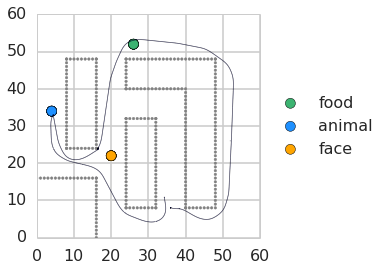

In [81]:
plot_paths(env='env1', subj='6', 
           dp=dp[dp.test_trial == 'training'], 
           proj=proj)

(<matplotlib.figure.Figure at 0x1d0b1ce10>,
 <matplotlib.axes.AxesSubplot at 0x1a3d3c9d0>)

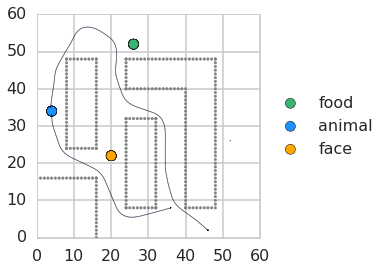

In [82]:
plot_paths(env='env1', subj='6', 
           dp=dp[dp.test_trial != 'training'], 
           proj=proj)

(<matplotlib.figure.Figure at 0x1d1b29c90>,
 <matplotlib.axes.AxesSubplot at 0x1df287990>)

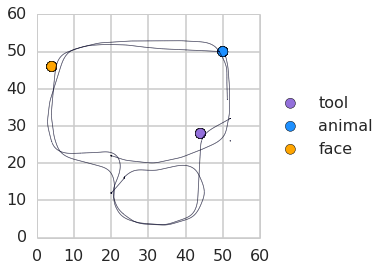

In [83]:
plot_paths(env='env3', subj='6', dp=dp, proj=proj)

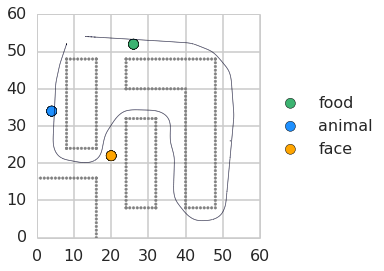

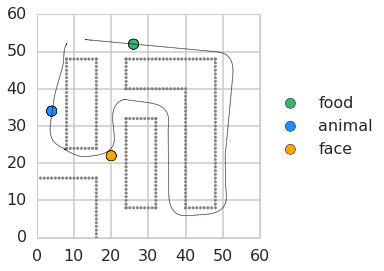

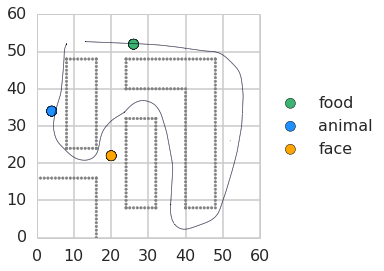

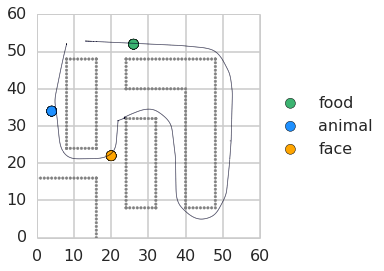

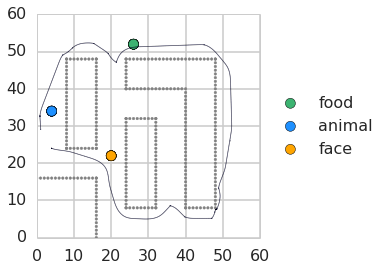

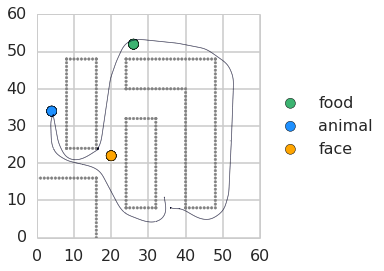

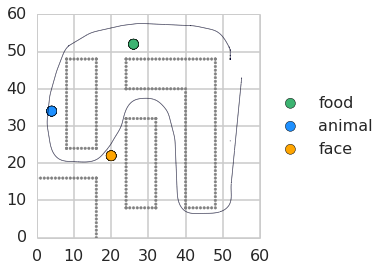

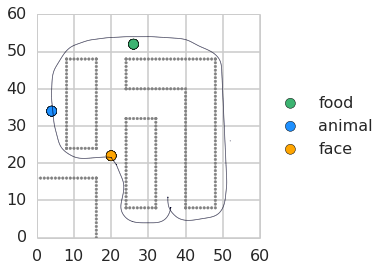

In [21]:
for i, sub in enumerate(subj_info.subid):
    fig, ax = plot_paths('env1', sub, dp, proj)

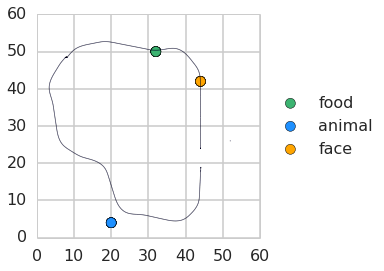

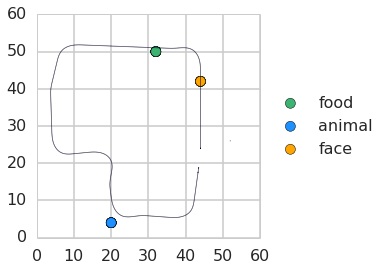

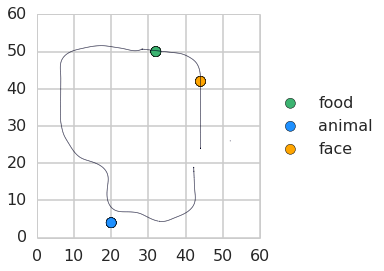

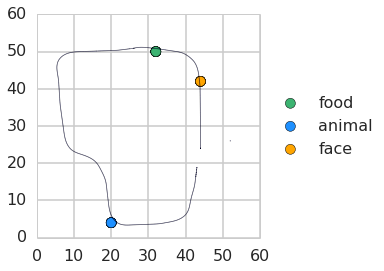

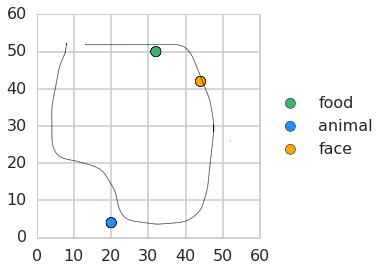

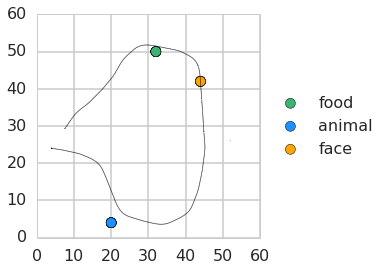

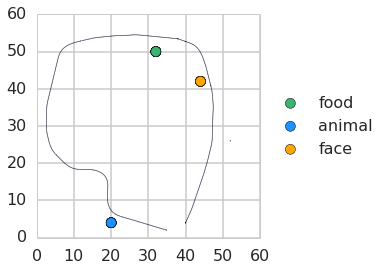

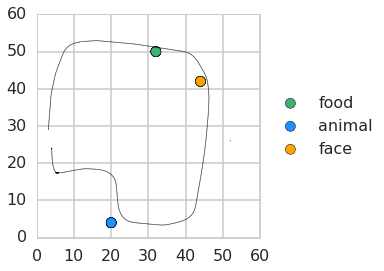

In [22]:
for i, sub in enumerate(subj_info.subid):
    fig, ax = plot_paths('env2', sub, dp, proj)

### Data for 1 subject, 1 environment

In [13]:
dsub = dp.query('env == "env1" & subid=="1" & c3=="PandaEPL_avatar"')
dsub.head()

,time,c3,subid,env,test_trial,x,y,z
5,6656,PandaEPL_avatar,1,env1,training,8,52,0.8
13,6656,PandaEPL_avatar,1,env1,training,8,52,0.8
15,6716,PandaEPL_avatar,1,env1,training,8,52,0.8
25,7086,PandaEPL_avatar,1,env1,training,8,52,0.8
27,7426,PandaEPL_avatar,1,env1,training,8,52,0.8


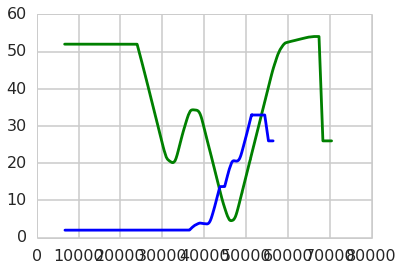

In [14]:
plt.plot(dsub[dsub.test_trial == 'training'].time, 
         dsub[dsub.test_trial == 'training'].y, 'green',
         dsub[dsub.test_trial == 'test1'].time, 
         dsub[dsub.test_trial == 'test1'].y, 'blue')

In [15]:
dsub.time.max()

70436

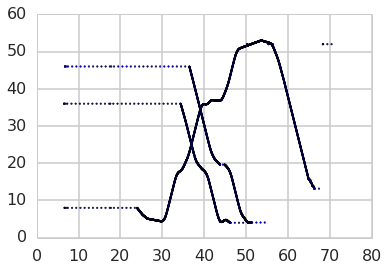

In [16]:
plt.scatter(dsub.time/1000, dsub.x.astype(float), 
            s=10, marker='.')

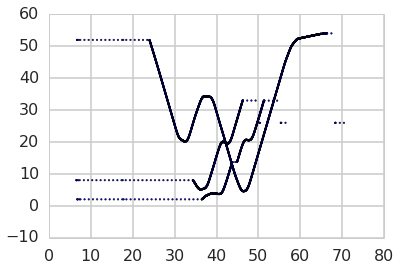

In [17]:
plt.scatter(dsub.time/1000, dsub.y.astype(float), 
            s=10, marker='.')

## Heading Direction

In [23]:
dh = df[(df.command == 'VROBJECT_HEADING') & (df.c3 == 'PandaEPL_avatar')].reset_index()
dh = dh.drop(['c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
dh.head()

,time,c2,c3,c4,subid,env,test_trial
0,6656,1,PandaEPL_avatar,90.0,1,env1,training
1,7986,21,PandaEPL_avatar,135.0,1,env1,training
2,9246,11,PandaEPL_avatar,180.0,1,env1,training
3,10506,11,PandaEPL_avatar,225.0,1,env1,training
4,11776,11,PandaEPL_avatar,270.0,1,env1,training


### Look at data just for 1 sub in 1 env

In [24]:
dsub = dh.query('env == "env3" & subid=="1"')
dsub.head()

,time,c2,c3,c4,subid,env,test_trial
3396,4173,1,PandaEPL_avatar,0.0,1,env3,training
3397,5503,21,PandaEPL_avatar,45.0,1,env3,training
3398,6753,21,PandaEPL_avatar,90.0,1,env3,training
3399,8003,21,PandaEPL_avatar,135.0,1,env3,training
3400,9273,11,PandaEPL_avatar,180.0,1,env3,training


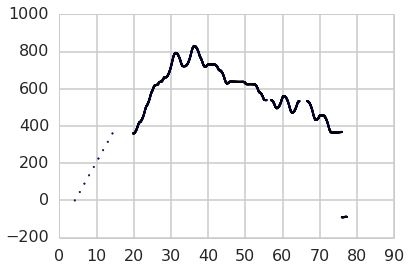

In [25]:
plt.scatter(dsub.time/1000, dsub.c4.astype(float), 
            s=10, marker='.')

## Text Events

In [86]:
dt = df[(df.command.isin(['ASSIGNED'])) 
        | df.command.isin(['ARRIVED'])].reset_index()
dt.ix[dt.command == 'ARRIVED', 'c3'] = 'between_trials'
dt = dt.drop(['c2', 'c4', 'c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
dt = dt.rename(columns={'c3': 'instructions'})
dt.head()

,time,instructions,subid,env,test_trial
0,17696,zzz,1,env1,training
1,66346,between_trials,1,env1,training
2,17778,zebra,1,env1,test1
3,51348,between_trials,1,env1,test1
4,17560,zebra,1,env1,test2


In [87]:
dt['total_time'] = (dt.time - dt.time.shift(1)).shift(-1)
dt.head()

,time,instructions,subid,env,test_trial,total_time
0,17696,zzz,1,env1,training,48650
1,66346,between_trials,1,env1,training,-48568
2,17778,zebra,1,env1,test1,33570
3,51348,between_trials,1,env1,test1,-33788
4,17560,zebra,1,env1,test2,28730


### Average time to navigate to goal

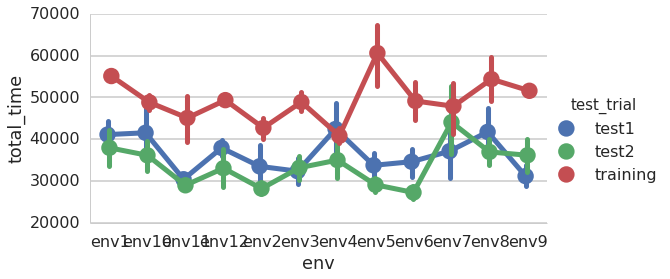

In [88]:
means = dt[dt.instructions != 'between_trials'].merge(subj_info).groupby(['subid', 'test_trial', 'env']).mean().reset_index()
sns.factorplot(x='env', y='total_time', aspect=2, hue='test_trial',
               units='subid', ci=68, dodge=.1,
               data=means)

## Input Events

In [29]:
di = df[(df.command == 'INPUT_EVENT')].reset_index()
di = di.drop(['c4', 'c5', 'c6', 'c7', 'c8', 'command', 'index'], 1) # remove unncessary cols
di = di.query('(c3 != "dismiss") & (c3 != "exit")')
di.head()

,time,c2,c3,subid,env,test_trial
0,22156,0,turnLeft,1,env1,training
1,22166,0,turnLeft,1,env1,training
2,22186,0,turnLeft,1,env1,training
3,22206,0,turnLeft,1,env1,training
4,22216,0,turnLeft,1,env1,training


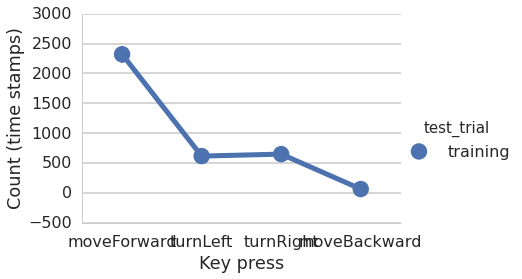

In [30]:
counts = di.merge(subj_info).groupby(['subid', 'test_trial', 'env', 'c3']).count().reset_index()

sns.factorplot(x='c3', y='time', aspect=1.5, hue='test_trial',
               units='subid', ci=68, data=counts)
plt.ylabel('Count (time stamps)')
plt.xlabel('Key press')

## Merge dataframes

In [89]:
dpt = dp.merge(dt, on=['subid', 'env', 'test_trial', 'time'], how='left')
dpt.ix[0,'instructions'] = 'intro'
dpt = dpt.fillna(method='ffill')
dpt.head()

,time,c3,subid,env,test_trial,x,y,z,instructions,total_time
0,6656,terrain,1,env1,training,0,0,0.0,intro,NaN
1,6656,zebra,1,env1,training,4,34,0.5,intro,NaN
2,6656,lettuce,1,env1,training,26,52,0.5,intro,NaN
3,6656,George_Clooney,1,env1,training,20,22,0.5,intro,NaN
4,6656,zzz,1,env1,training,12,52,0.2,intro,NaN


In [90]:
dpt.query('env == "env1" & c3 == "lettuce"')

,time,c3,subid,env,test_trial,x,y,z,instructions,total_time
2,6656,lettuce,1,env1,training,26,52,0.5,intro,NaN
2653,6736,lettuce,1,env1,test1,26,52,0.5,between_trials,-48568
3621,6518,lettuce,1,env1,test2,26,52,0.5,between_trials,-33788
58242,6906,lettuce,2,env1,training,26,52,0.5,between_trials,-27892
60987,6886,lettuce,2,env1,test1,26,52,0.5,between_trials,-54070
62928,6498,lettuce,2,env1,test2,26,52,0.5,between_trials,-46198
120499,6863,lettuce,3,env1,training,26,52,0.5,between_trials,-23884
123228,7272,lettuce,3,env1,test1,26,52,0.5,between_trials,-53661
124639,6684,lettuce,3,env1,test2,26,52,0.5,between_trials,-40838
184585,6971,lettuce,4,env1,training,26,52,0.5,between_trials,-24027


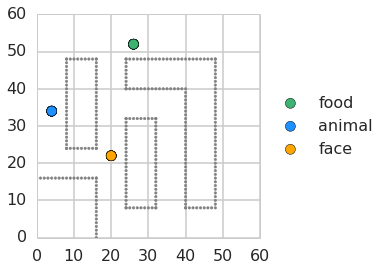

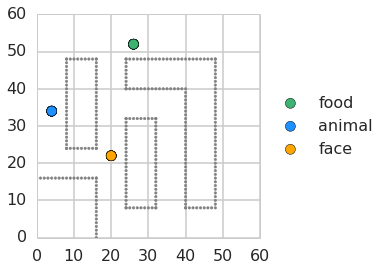

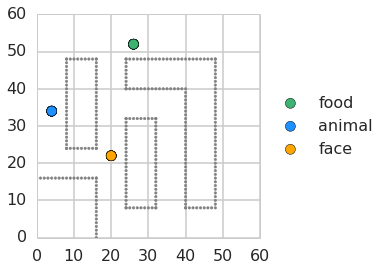

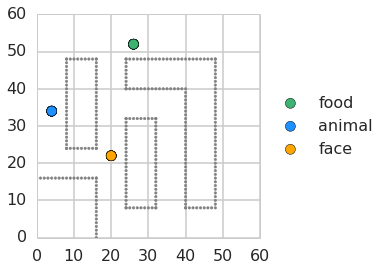

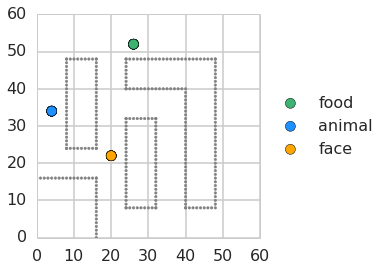

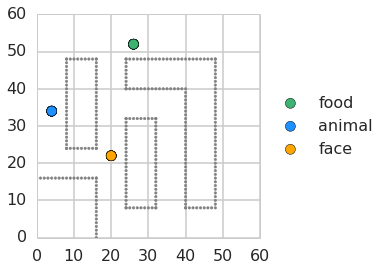

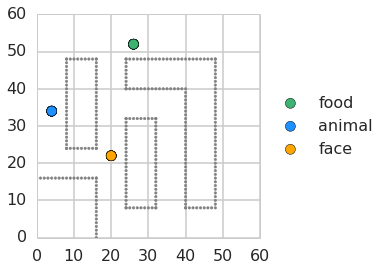

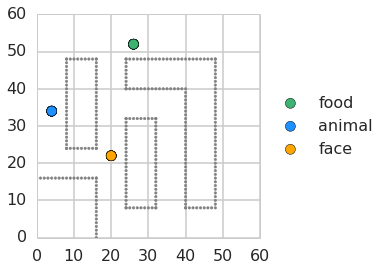

In [35]:
for i, sub in enumerate(subj_info.subid):
    fig, ax = plot_path('env1', sub, 'zebra', dpt, proj, dp)

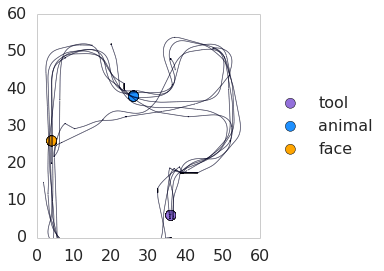

In [177]:
plot_paths_group('env5', subj_info.subid, 
                 dpt.query('test_trial == "training"'), proj, dp)
plt.grid(0)

<module 'matplotlib.pyplot' from '/Users/sgagnon/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

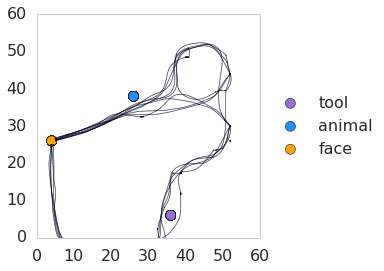

In [178]:
plot_paths_group('env5', subj_info.subid, 
                 dpt.query('test_trial != "training"'), proj, dp)
plt.grid(0)
plt

## Code to figure out how many subjects took shortcuts:

In [180]:
data_test = dpt.query('test_trial != "training"')
test_types = ['test1', 'test2']

total_subjs = len(data_test.subid.unique())

dshortcuts = pd.DataFrame(columns=['env', 'test_num', 'shortcuts'])
for env in proj['envs']:
    sc = shortcut_coords[shortcut_coords.env==env]
    for test in test_types:
        subs= data_test[(data_test.test_trial == test) &
                        (data_test.env == env) &
                        (data_test.x < sc.x_hi.values[0]) & 
                        (data_test.x > sc.x_lo.values[0]) & 
                        (data_test.y < sc.y_hi.values[0]) &
                        (data_test.y > sc.y_lo.values[0])].subid.unique()
        
        row = {'env': env, 
               'test_num': test, 
               'shortcuts': float(len(subs))/total_subjs}
        dshortcuts = dshortcuts.append(row, ignore_index=True)

In [181]:
dshortcuts.head()

,env,test_num,shortcuts
0,env1,test1,0.142857
1,env1,test2,0.571429
2,env2,test1,0.428571
3,env2,test2,0.428571
4,env3,test1,0.571429


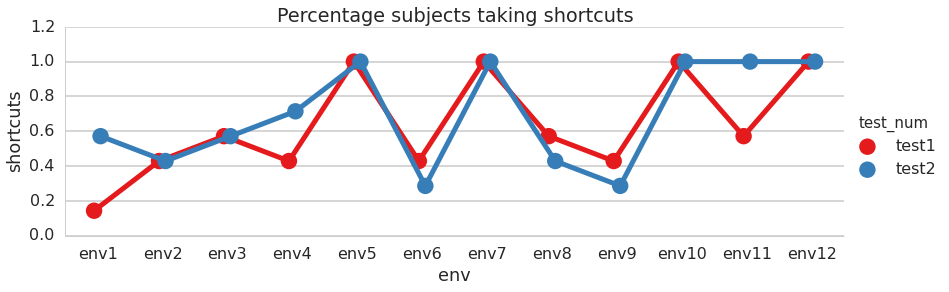

In [182]:
sns.factorplot(x='env', y='shortcuts', aspect=3, hue='test_num',
               dodge=.1,
               data=dshortcuts, 
               palette='Set1')
plt.title('Percentage subjects taking shortcuts')

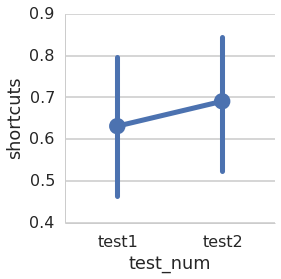

In [183]:
sns.factorplot(x='test_num', y='shortcuts', 
               dodge=.1,
               data=dshortcuts)

## Calculate Path Lengths

In [104]:
dpt.head()

,time,c3,subid,env,test_trial,x,y,z,instructions,total_time
0,6656,terrain,1,env1,training,0,0,0.0,intro,NaN
1,6656,zebra,1,env1,training,4,34,0.5,intro,NaN
2,6656,lettuce,1,env1,training,26,52,0.5,intro,NaN
3,6656,George_Clooney,1,env1,training,20,22,0.5,intro,NaN
4,6656,zzz,1,env1,training,12,52,0.2,intro,NaN


In [105]:
dplen = pd.DataFrame(columns=['subid', 'env', 'goal_type', 'path_len'])

for env in proj['envs']:
    goals = set(dpt[dpt.env == env].instructions)
    goals.discard('between_trials')
    goals.discard('intro')

    for subid in subj_info.subid:
#         print subid
        
        for goal in goals:
#             print goal

            goal_type = dict((v,k) for k,v in proj['goals'][env].items()).get(goal)
#             print goal_type
            data_sub = dpt[(dpt.subid == subid) & (dpt.env == env) & 
                           (dpt.instructions == goal) & 
                           (dpt.c3 == 'PandaEPL_avatar')]
            distance = sp.spatial.distance.euclidean(data_sub.x, data_sub.y)
            
            row = pd.Series({'subid': subid,
                             'env': env,
                             'goal_type': goal_type,
                             'path_len': distance})
            dplen = dplen.append(row, ignore_index=True)

In [106]:
dplen.head()

,subid,env,goal_type,path_len
0,1,env1,None,1259.605132
1,1,env1,animal,839.519945
2,2,env1,None,1231.693554
3,2,env1,animal,1530.083381
4,3,env1,None,1279.596593


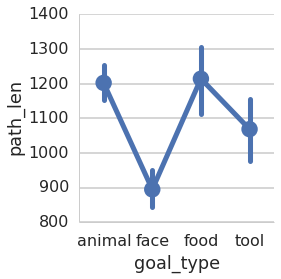

In [107]:
means = dplen.merge(subj_info).groupby(['subid', 'goal_type']).mean().reset_index()

sns.factorplot(x='goal_type', y='path_len', 
               units='subid', ci=68, dodge=.1,
               data=means)

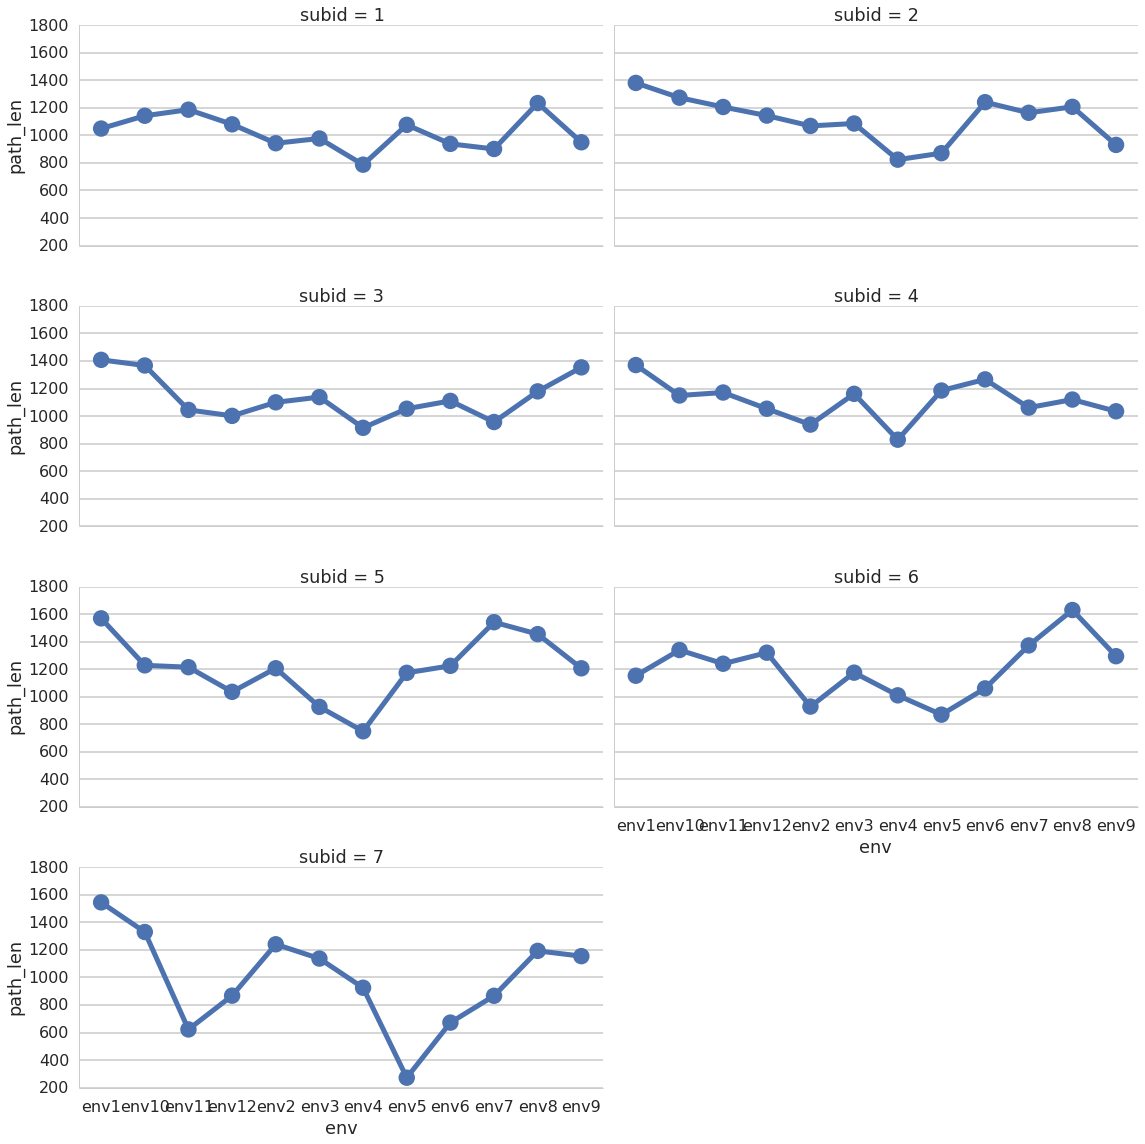

In [108]:
means = dplen.merge(subj_info).groupby(['subid', 'env']).mean().reset_index()

sns.factorplot(x='env', y='path_len', aspect=2,
               col='subid', col_wrap=2,
               dodge=.1,
               data=means)

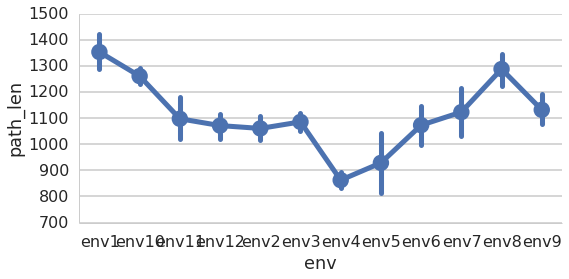

In [109]:
means = dplen.merge(subj_info).groupby(['subid', 'env']).mean().reset_index()

sns.factorplot(x='env', y='path_len', aspect=2,
               units='subid', ci=68, dodge=.1,
               data=means, )